In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision'

/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision


In [11]:
# Load the numpy and panda package for linear algebra and data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Imports packages to view data
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
import cv2
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

# Import keras packages
from keras import applications
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.data_utils import Sequence
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load the data 
data_dir  = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/'
train_dir = os.path.join(data_dir,'train/')
val_dir = os.path.join(data_dir,'val/')
test_dir = os.path.join(data_dir,'test/')

# Setting Seeds for Reproducibility
# seed = 231
# np.random.seed(seed)
# tf.random.set_seed(seed)

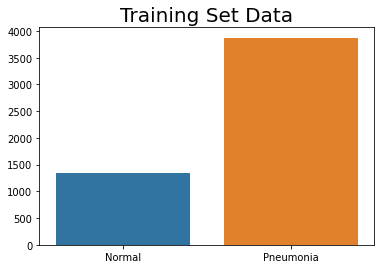

In [13]:
path = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/'
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data', fontsize=20)
plt.show()

In [14]:
training_images = tf.io.gfile.glob('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train/*/*')
validation_images = tf.io.gfile.glob('./content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val/*/*')

# Data before split
print(f'Before division of 80:20')
print(f'Total number of training images = {len(training_images)}')
print(f'Total number of validation images = {len(validation_images)}\n')

# Merge the training and validation, to split them afterwards
total_files = training_images
total_files.extend(validation_images)
print(f'Total number of images : training_images + validation_images = {len(total_files)}\n')

# Spliting 80:20
train_images, val_images = train_test_split(total_files, test_size = 0.2)
print(f'After division of 80:20')
print(f'Total number of training images = {len(train_images)}')
print(f'Total number of validation images = {len(val_images)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 0

Total number of images : training_images + validation_images = 5216

After division of 80:20
Total number of training images = 4172
Total number of validation images = 1044


In [15]:
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/negative/')
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/positive/')
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/negative/')
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/positive/')

In [16]:
# Train images
for ele in train_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/negative/' +  parts_of_path[-1])

# Validation images
for ele in val_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/negative/' +  parts_of_path[-1])

# ** Data augmentation**

In [17]:
from prettytable import PrettyTable 
mytable = PrettyTable(["Method", "Setting"], 
                     title = "Settings for the image augmentation.") 
  
# Add rows 
mytable.add_row(["Rescale", "1/255"])
mytable.add_row(["Zoom Range", "0.3"]) 
mytable.add_row(["Vertical Flip", "True"]) 

print(mytable)

+------------------------------------+
| Settings for the image augmentation. |
+----------------------+-------------+
|        Method        |   Setting   |
+----------------------+-------------+
|       Rescale        |    1/255    |
|      Zoom Range      |     0.3     |
|    Vertical Flip     |     True    |
+----------------------+-------------+


In [18]:
# Hyperparameters
image_size = 150
epochs = 20
batch_size = 32

In [19]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   zoom_range = 0.3,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1, 
                                   horizontal_flip = True,
                                   samplewise_center = True, 
                                   rotation_range = 0.3,
                                   samplewise_std_normalization = False, 
                                   featurewise_std_normalization = False,
                                   vertical_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

validation_gen = val_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

test_gen = test_datagen.flow_from_directory(
     '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/test',
    target_size = (image_size, image_size),
    batch_size = batch_size , 
    class_mode = 'binary'
)

Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
count_normal = len([x for x in train_images if "NORMAL" in x])
count_pneumonia = len([x for x in train_images if "PNEUMONIA" in x])

bias = np.log([count_pneumonia/count_normal])
bias

weight_for_0 = (1 / count_normal)*(len(train_images))/2.0 
weight_for_1 = (1 / count_pneumonia)*(len(train_images))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


# **CNN model**

In [21]:
# Callbacks for Regularization
checkpoint = ModelCheckpoint(filepath='best_weights.CNN', 
                             save_best_only=True 
                             #save_weights_only=True
                            )
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=2, 
                              mode='max')

In [22]:
CNN = tf.keras.models.Sequential([
    
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fourth convolution
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Output layer, only 1 output neuron: it will contain a value from 0-1 
    tf.keras.layers.Dense(1, activation='sigmoid'),
    
])

In [23]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                          

In [24]:
# Compile our model
CNN.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy','Recall', 'Precision'])

In [25]:
# Fitting the model
histCNN = CNN.fit_generator(
    train_gen, 
    steps_per_epoch = train_gen.samples // batch_size, 
    epochs = epochs, 
    validation_data = validation_gen, 
    validation_steps = validation_gen.samples // batch_size, 
    class_weight = class_weight, 
    callbacks = [checkpoint, lr_reduce])

<ipython-input-25-22c3dfd5a3c1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  histCNN = CNN.fit_generator(


Epoch 1/20
130/130 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.7826 - recall: 0.7549 - precision: 0.9422

130/130 [==============================] - 91s 651ms/step - loss: 0.4396 - accuracy: 0.7826 - recall: 0.7549 - precision: 0.9422 - val_loss: 0.6033 - val_accuracy: 0.7295 - val_recall: 1.0000 - val_precision: 0.7295 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 83s 640ms/step - loss: 0.3287 - accuracy: 0.8517 - recall: 0.8287 - precision: 0.9679 - val_loss: 0.8479 - val_accuracy: 0.7324 - val_recall: 1.0000 - val_precision: 0.7324 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 79s 612ms/step - loss: 0.3045 - accuracy: 0.8671 - recall: 0.8518 - precision: 0.9662 - val_loss: 1.2453 - val_accuracy: 0.7275 - val_recall: 1.0000 - val_precision: 0.7275 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 78s 598ms/step - loss: 0.2844 - accuracy: 0.8807 - recall: 0.8629 - precision: 0.9744 - val_loss: 0.8083 - val_accuracy: 0.7266 - val_recall: 1.0000 - val_precision: 0.7266 - lr: 0.0010
Epoch 5/20
130/130 [==============================]

130/130 [==============================] - 86s 661ms/step - loss: 0.2398 - accuracy: 0.9039 - recall: 0.8984 - precision: 0.9706 - val_loss: 0.2169 - val_accuracy: 0.9170 - val_recall: 0.9223 - val_precision: 0.9622 - lr: 0.0010
Epoch 7/20
130/130 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9034 - recall: 0.8963 - precision: 0.9723
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
130/130 [==============================] - 77s 595ms/step - loss: 0.2493 - accuracy: 0.9034 - recall: 0.8963 - precision: 0.9723 - val_loss: 0.7002 - val_accuracy: 0.7627 - val_recall: 0.9987 - val_precision: 0.7558 - lr: 0.0010
Epoch 8/20
130/130 [==============================] - 77s 595ms/step - loss: 0.2104 - accuracy: 0.9157 - recall: 0.9058 - precision: 0.9797 - val_loss: 1.4346 - val_accuracy: 0.7402 - val_recall: 1.0000 - val_precision: 0.7374 - lr: 3.0000e-04
Epoch 9/20
130/130 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 

## **Vizualising Model performances**

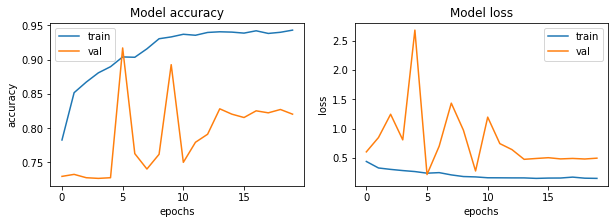

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(histCNN.history[met])
    ax[i].plot(histCNN.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**Predict and Evaluate**

In [27]:
test_result_CNN = CNN.evaluate_generator(test_gen, 624)
print('Loss rate at test data :', test_result_CNN[0])
print('Accuracy rate at test data :', test_result_CNN[1])
print('Recall rate at test data :', test_result_CNN[2])
print('Precision rate at test data :', test_result_CNN[3])

<ipython-input-27-a01fab334098>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_result_CNN = CNN.evaluate_generator(test_gen, 624)


Loss rate at test data : 1.5734301805496216
Accuracy rate at test data : 0.6682692170143127
Recall rate at test data : 0.9871794581413269
Precision rate at test data : 0.6558773517608643


# **Prediction Plots**

In [28]:
Inception_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/best_weights.CNN')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 32 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_gen[i][0][j]).reshape(1,150,150,3)
        
        prediction = Inception_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_gen[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
#        print(len(correct_predicted_image[0]),len(wrong_predicted_image[0]))
        j += 1
        
    i += 1

1/1 [==============================] - 0s 16ms/step


wrong_prediction_by_model --- [0, 1, 0, 1, 0, 1]


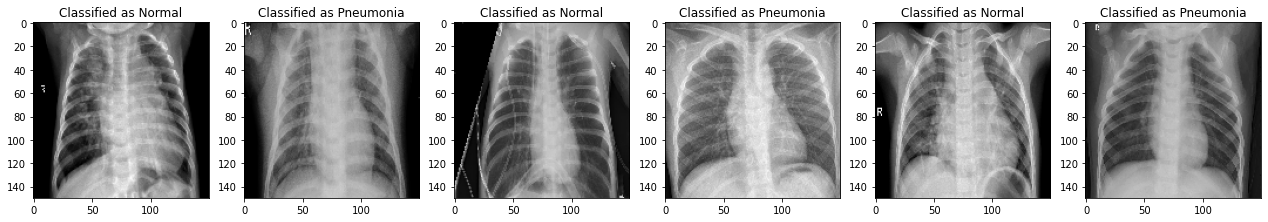

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(150,150,3))
    ax[i].imshow(image)
    if wrong_predicted_image[1][i] == 1:
        ax[i].set_title("Classified as Pneumonia")
    else:
        ax[i].set_title("Classified as Normal")
    i += 1

print(f'wrong_prediction_by_model --- {wrong_predicted_image[1]}')

correct_prediction_by_model --- [1, 1, 1, 1, 1, 0]


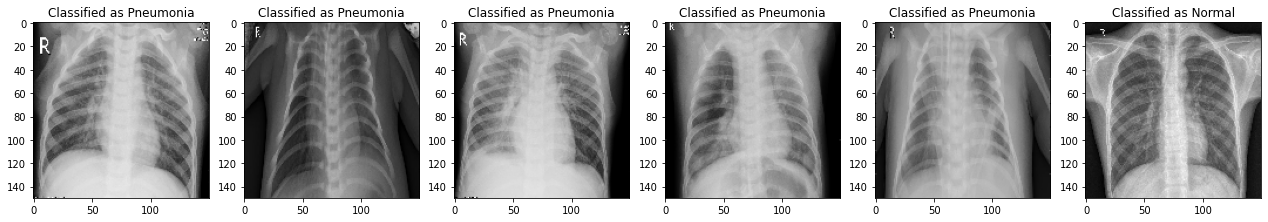

In [30]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(150,150,3))
    ax[i].imshow(image)
    if correct_predicted_image[1][i] == 1:
        ax[i].set_title("Classified as Pneumonia")
    else:
        ax[i].set_title("Classified as Normal")
    i += 1

print(f'correct_prediction_by_model --- {correct_predicted_image[1]}')

# **VGG-16 Model **
**VGG-16 Model: Pretrained Model**

In [31]:
# Hyperparameters
image_size = 224
epochs = 20
batch_size = 64

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   zoom_range = 0.3,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1, 
                                   horizontal_flip = True,
                                   samplewise_center = True, 
                                   rotation_range = 0.3,
                                   samplewise_std_normalization = False, 
                                   featurewise_std_normalization = False,
                                   vertical_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

validation_gen = val_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

test_gen = test_datagen.flow_from_directory(
     '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/test/',
    target_size = (image_size, image_size),
    batch_size = batch_size , 
    class_mode = 'binary'
)

Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
base_VGG = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3),
                                       include_top=False, 
                                       weights='imagenet')
base_VGG.trainable = False

# Add some layers which we found to be 
VGG = tf.keras.Sequential([
        base_VGG,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

# Compile our model
VGG.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy', 'Recall', 'Precision'])
VGG.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [33]:
print(len(base_VGG.layers))

19


In [34]:
# Callbacks for Regularization
checkpoint = ModelCheckpoint(filepath='best_weights.VGG', 
                             save_best_only=True 
                             #save_weights_only=True
                            )
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=2, 
                              mode='max')

In [35]:
histVGG = VGG.fit_generator(
    train_gen, 
    steps_per_epoch = train_gen.samples // batch_size, 
    epochs = epochs, 
    validation_data = validation_gen, 
    validation_steps = validation_gen.samples // batch_size,
    class_weight = class_weight,
    callbacks= [checkpoint, lr_reduce])

<ipython-input-35-6777d480fee9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  histVGG = VGG.fit_generator(


Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.8169 - recall: 0.8140 - precision: 0.9320

65/65 [==============================] - 114s 2s/step - loss: 0.5310 - accuracy: 0.8169 - recall: 0.8140 - precision: 0.9320 - val_loss: 0.3091 - val_accuracy: 0.8789 - val_recall: 0.8380 - val_precision: 0.9952 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.8946 - recall: 0.8843 - precision: 0.9716

65/65 [==============================] - 107s 2s/step - loss: 0.2545 - accuracy: 0.8946 - recall: 0.8843 - precision: 0.9716 - val_loss: 0.2855 - val_accuracy: 0.8926 - val_recall: 0.8566 - val_precision: 0.9953 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - 104s 2s/step - loss: 0.2048 - accuracy: 0.9153 - recall: 0.9092 - precision: 0.9755 - val_loss: 0.4440 - val_accuracy: 0.8418 - val_recall: 0.7848 - val_precision: 0.9983 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9182 - recall: 0.9081 - precision: 0.9810

65/65 [==============================] - 104s 2s/step - loss: 0.2053 - accuracy: 0.9182 - recall: 0.9081 - precision: 0.9810 - val_loss: 0.1537 - val_accuracy: 0.9434 - val_recall: 0.9290 - val_precision: 0.9928 - lr: 0.0010
Epoch 5/20
65/65 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9204 - recall: 0.9142 - precision: 0.9777
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
65/65 [==============================] - 102s 2s/step - loss: 0.1946 - accuracy: 0.9204 - recall: 0.9142 - precision: 0.9777 - val_loss: 0.4316 - val_accuracy: 0.8516 - val_recall: 0.7973 - val_precision: 0.9983 - lr: 0.0010
Epoch 6/20
65/65 [==============================] - 103s 2s/step - loss: 0.1668 - accuracy: 0.9340 - recall: 0.9288 - precision: 0.9817 - val_loss: 0.2793 - val_accuracy: 0.9004 - val_recall: 0.8671 - val_precision: 0.9954 - lr: 3.0000e-04
Epoch 7/20
65/65 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9421 - recall:

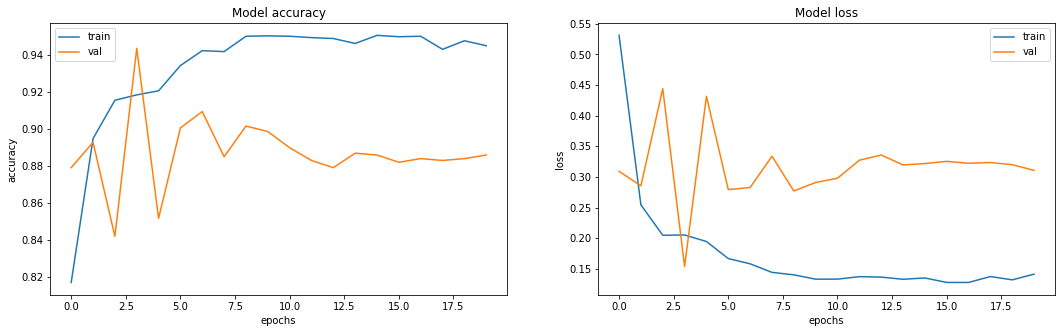

In [36]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(histVGG.history[element])
    axis[i].plot(histVGG.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

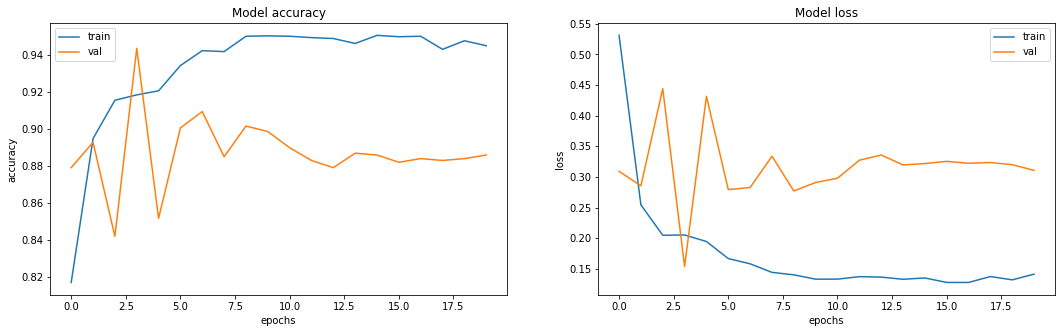

In [37]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(histVGG.history[element])
    axis[i].plot(histVGG.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [38]:
test_result_VGG = VGG.evaluate_generator(test_gen, 624)
print('Loss rate at test data :', test_result_VGG[0])
print('Accuracy rate at test data :', test_result_VGG[1])
print('Recall rate at test data :', test_result_VGG[2])
print('Precision rate at test data :', test_result_CNN[3])

<ipython-input-38-b45032eedaf3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_result_VGG = VGG.evaluate_generator(test_gen, 624)


Loss rate at test data : 0.26105865836143494
Accuracy rate at test data : 0.8974359035491943
Recall rate at test data : 0.8999999761581421
Precision rate at test data : 0.6558773517608643


In [39]:
Inception_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/best_weights.VGG')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 32 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_gen[i][0][j]).reshape(1,224,224,3)
        
        prediction = Inception_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_gen[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
#        print(len(correct_predicted_image[0]),len(wrong_predicted_image[0]))
        j += 1
        
    i += 1

1/1 [==============================] - 0s 17ms/step


wrong_prediction_by_model --- [1, 1, 1, 1, 0, 1]


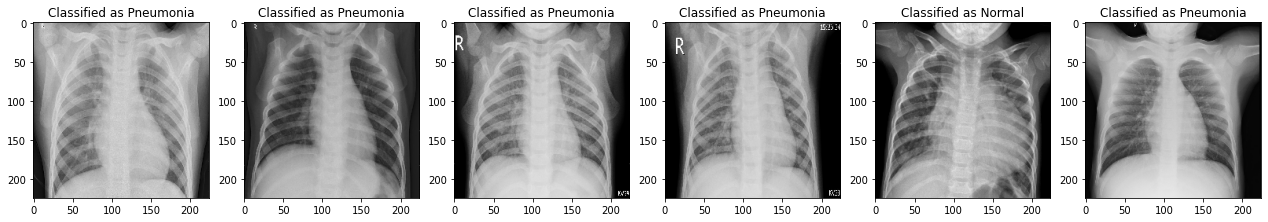

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    ax[i].imshow(image)
    if wrong_predicted_image[1][i] == 1:
        ax[i].set_title("Classified as Pneumonia")
    else:
        ax[i].set_title("Classified as Normal")
    i += 1

print(f'wrong_prediction_by_model --- {wrong_predicted_image[1]}')

correct_prediction_by_model --- [0, 1, 0, 0, 1, 1]


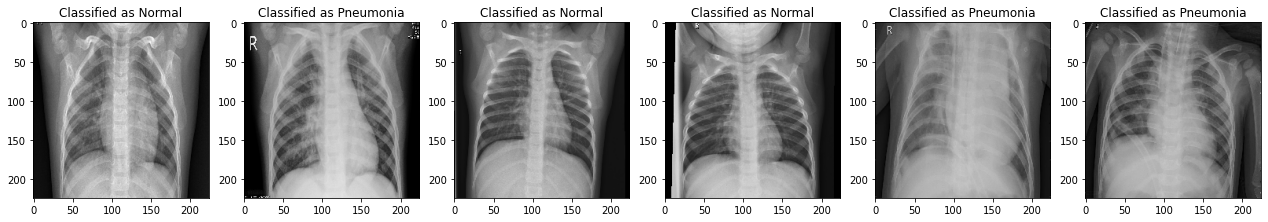

In [41]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    ax[i].imshow(image)
    if correct_predicted_image[1][i] == 1:
        ax[i].set_title("Classified as Pneumonia")
    else:
        ax[i].set_title("Classified as Normal")
    i += 1

print(f'correct_prediction_by_model --- {correct_predicted_image[1]}')

In [42]:
# Import ResNet-50
from tensorflow.keras.applications.resnet50 import ResNet50

base_resnet = ResNet50(input_shape=(image_size, image_size, 3),
                                                     include_top=False, 
                                                     weights='imagenet')
# base_resnet.trainable = False
# Freazing the base trained layers
for layers in base_resnet.layers:
    layers.trainable = False

# Add some layers which we found to be 
ResNet = tf.keras.Sequential([
        base_resnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
     #  tf.keras.layers.Dense(2048, activation='relu'),
     #  tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

# Compile our model
ResNet.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy', 'Recall', 'Precision'])

# ResNet.summary()

In [43]:
checkpoint = ModelCheckpoint(filepath='best_weights.ResNet', 
                             save_best_only=True 
                             # save_weights_only=True
                            )
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=2, 
                              mode='max')

In [44]:
print(len(base_resnet.layers))

175


In [45]:
histResNet = ResNet.fit_generator(
    train_gen, 
    steps_per_epoch = train_gen.samples // batch_size, 
    epochs = epochs, 
    validation_data = validation_gen, 
    validation_steps = validation_gen.samples // batch_size, 
    class_weight = class_weight,
    callbacks= [checkpoint, lr_reduce])

<ipython-input-45-016296045c47>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  histResNet = ResNet.fit_generator(


Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.5319 - recall: 0.5090 - precision: 0.7887

65/65 [==============================] - 127s 2s/step - loss: 0.7224 - accuracy: 0.5319 - recall: 0.5090 - precision: 0.7887 - val_loss: 0.5643 - val_accuracy: 0.8184 - val_recall: 0.8947 - val_precision: 0.8625 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - 99s 2s/step - loss: 0.5994 - accuracy: 0.7130 - recall: 0.7290 - precision: 0.8658 - val_loss: 0.7664 - val_accuracy: 0.4395 - val_recall: 0.2322 - val_precision: 0.9886 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - 102s 2s/step - loss: 0.5878 - accuracy: 0.6972 - recall: 0.7032 - precision: 0.8663 - val_loss: 0.7544 - val_accuracy: 0.5078 - val_recall: 0.3271 - val_precision: 0.9919 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7366 - recall: 0.7439 - precision: 0.8852


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
65/65 [==============================] - 121s 2s/step - loss: 0.5555 - accuracy: 0.7366 - recall: 0.7439 - precision: 0.8852 - val_loss: 0.4061 - val_accuracy: 0.8311 - val_recall: 0.9075 - val_precision: 0.8668 - lr: 0.0010
Epoch 5/20
65/65 [==============================] - 99s 2s/step - loss: 0.5251 - accuracy: 0.7612 - recall: 0.7659 - precision: 0.8993 - val_loss: 0.4873 - val_accuracy: 0.8193 - val_recall: 0.7869 - val_precision: 0.9576 - lr: 3.0000e-04
Epoch 6/20
65/65 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.7561 - recall: 0.7632 - precision: 0.8950
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
65/65 [==============================] - 101s 2s/step - loss: 0.5276 - accuracy: 0.7561 - recall: 0.7632 - precision: 0.8950 - val_loss: 0.4550 - val_accuracy: 0.8271 - val_recall: 0.8132 - val_precision: 0.9409 - lr: 3.0000e-04
Epoch 7/20
65/65 [=====

In [46]:
test_result_ResNet = ResNet.evaluate_generator(test_gen, 624)
print('Loss rate at test data :', test_result_ResNet[0])
print('Accuracy rate at test data :', test_result_ResNet[1])
print('Recall rate at test data :', test_result_ResNet[2])
print('Precision rate at test data :', test_result_CNN[3])

<ipython-input-46-561625cd980d>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_result_ResNet = ResNet.evaluate_generator(test_gen, 624)


Loss rate at test data : 0.5274105668067932
Accuracy rate at test data : 0.7964743375778198
Recall rate at test data : 0.7692307829856873
Precision rate at test data : 0.6558773517608643


In [47]:
Inception_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/best_weights.ResNet')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 32 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_gen[i][0][j]).reshape(1,224,224,3)
        
        prediction = Inception_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_gen[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
#        print(len(correct_predicted_image[0]),len(wrong_predicted_image[0]))
        j += 1
        
    i += 1

1/1 [==============================] - 0s 22ms/step


wrong_prediction_by_model --- [1, 1, 1, 0, 1, 1]


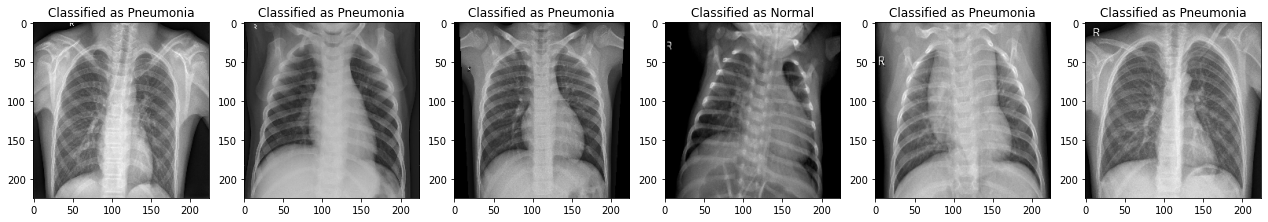

In [48]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    ax[i].imshow(image)
    if wrong_predicted_image[1][i] == 1:
        ax[i].set_title("Classified as Pneumonia")
    else:
        ax[i].set_title("Classified as Normal")
    i += 1

print(f'wrong_prediction_by_model --- {wrong_predicted_image[1]}')


correct_prediction_by_model --- [1, 0, 0, 1, 1, 1]


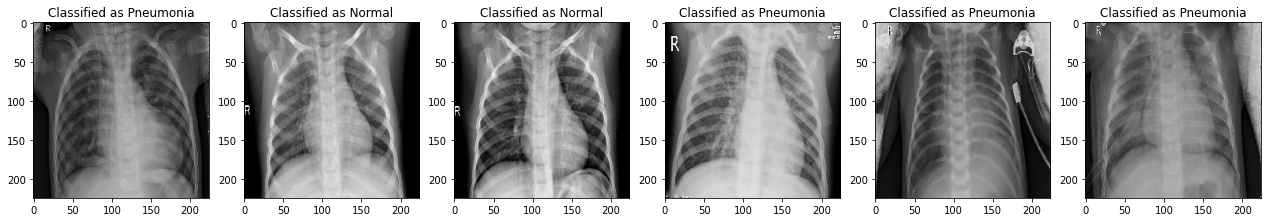

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    ax[i].imshow(image)
    if correct_predicted_image[1][i] == 1:
        ax[i].set_title("Classified as Pneumonia")
    else:
        ax[i].set_title("Classified as Normal")
    i += 1

print(f'correct_prediction_by_model --- {correct_predicted_image[1]}')